## Week 2 Lab exercises

In this week we will use python to explore strange new worlds, to seek out new life and new civilisation, and to boldly code what no one has coded before. 

The goal is to familiarise yourself with using functions, loops, arrays and plotting in Python, and to illustrate some of the software carpentry points that we discussed in the lecture.

In [11]:
# first we import the libraries we need
import numpy as np
import matplotlib.pyplot as plt
import time

# The following lines makes the plots appear in another window - if using AppsAnywhere they may appear
# in another window behind the notebook, and you may have to rearrange the desktop to see them. However, 
# I've commented it out because it doesn't always work. You can try it if you have time.
# %matplotlib 

# This makes the plots appear in the notebook
%matplotlib inline

### ACTIVITY 1: 
In the code below, change the line as marked (UPDATE ME) to get the asteroid data from the data file `asteroid_locations.dat` that is in the `/data` folder

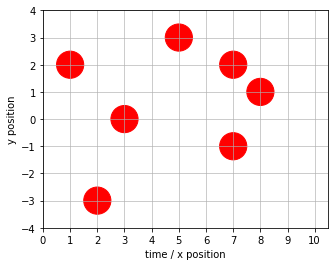

In [12]:
# Set up the plotting

def plot_asteroid_field(ax) :
    plt.axis([0,10.5,-4,4])
    major_ticks = np.arange(0, 11, 1)
    ax.set_xticks(major_ticks)
    plt.xlabel("time / x position")
    plt.ylabel("y position")
    ax.set_aspect('equal')
    ax.grid(which='major', alpha=0.8)

    # Mark the asteroid positions onto the plot - read in the data from data/asteroid_locations.dat
    # HINT: the function you need is called loadtxt
    asteroid_locations= np.loadtxt("data/asteroid_locations.dat")
    for location in asteroid_locations :
        circle=plt.Circle(location, 0.5 , color='r')
        ax.add_artist(circle)
    plt.pause(0.3)

# Test the plot
fig = plt.figure()
ax = plt.gcf().gca()
plot_asteroid_field(ax)
plt.show()

In [6]:
# set up a list to store the times and positions
list_of_times = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
list_of_y_positions = np.zeros_like(list_of_times)

# print off the initial values of the times and positions
print("The list of times at the start is ", list_of_times)
print("The list of y positions at the start is ", list_of_y_positions)

NameError: name 'np' is not defined

### ACTIVITY 2: 

Captain Katy has asked you to plot a flight path through the asteroid field. If you run the code below you will see that the path does not currently avoid the asteroids :-( Update it so that it does! 

Also update so that the distance moved is calculated, and try to minimise this.

RULES:

- Just like in a retro video game, the ship must move one step forward in the x direction at every timestep, and you can only change its movement in the y direction to avoid the asteroids.
- You should move in whole steps in the (x and) y direction, so you are always on integer coordinates.
- You must end the flight back at position y=0.
- Don't hit the asteroids! Note that their radius is 0.5 of a distance unit, so it is not sufficient to simply avoid the coordinates on which they are centred.

#### BUT FIRST

Remember *defensive programming*? You will see that the code does not check that it does what it should - i.e., it does not check that we have not hit an asteroid, and that we return to the zero position at the last step. Implement tests to check the rules _BEFORE_ you implement the code to set the path, and use asserts to make it quit with an error message if it fails.

*TIP: You probably want to write any tests as a separate function. Would it be better to call them at each step or just at the end?*

In [7]:
# First make the tests

# Rule 1: always moving forward in x
# Note the need for .all() to enforce equality for all elements
def test_x_movement_unmodified(a_list_of_times) :
    time_size = np.size(a_list_of_times)
    assert (a_list_of_times == np.arange(time_size)).all(), 'It is illegal to change the time / x steps'

# Test for the test
# broken_list_of_times = np.array([1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# test_x_movement_unmodified(broken_list_of_times)

# Rule 2: move in whole steps
# Note that by definition the type of all elements of a numpy array are
# the same
def test_y_movement_integer(a_list_of_y_positions) :
    assert (a_list_of_y_positions.dtype == 'int64'), 'It is illegal to move in non integer steps'

# Test for the test
# broken_list_of_y_positions = np.array([0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# test_y_movement_integer(broken_list_of_y_positions)

# Rule 3: end back at position y=0
def test_final_position(a_list_of_y_positions) :
    last_index = np.size(a_list_of_y_positions) - 1
    assert a_list_of_y_positions[last_index] == 0, 'You must end at y=0'

# Test for the test
# broken_list_of_y_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10])
# test_final_position(broken_list_of_y_positions)

# Rule 4: Avoid the asteroids!
def test_avoiding_asteroids(a_list_of_times, a_list_of_y_positions) :
    asteroid_locations= np.loadtxt("data/asteroid_locations.dat")
    
    
    # This one just tests we are avoiding the asteroids at the integer locations
    for iloc, location in enumerate(asteroid_locations) :
        for ix, x_position in enumerate(a_list_of_times) :
            distance_to_asteroid = np.sqrt((location[0] - x_position)**2.0 
                                         + (location[1] - a_list_of_y_positions[ix])**2.0)
            message = 'You have hit an asteroid at ' + str(location)
            assert distance_to_asteroid > 0.5, message
            
    # this one does the harder case of actually making sure the lines don't cross the spheres 
    for iloc, location in enumerate(asteroid_locations) :    
        for ix, x_position in enumerate(a_list_of_times) :
            if ix > 0 : # skip the first point
                
                # First find the equation of the line through 
                # the segment between point ix and ix-1
                # y = mx + c
                # For readability assign new names to the elements here, and make sure
                # they are treated as floats
                x2 = float(a_list_of_times[ix])
                x1 = float(a_list_of_times[ix-1])
                y2 = float(a_list_of_y_positions[ix])
                y1 = float(a_list_of_y_positions[ix-1])
                x_asteroid = float(location[0])
                y_asteroid = float(location[1])
                m_line = (y2 - y1) / (x2 - x1)
                c_line = y1 - m_line * x1
                
                # The line that intersects perpendicularly
                # Treat the special case of zero gradient
                # (Note that we can never have a vertical line as we always need to 
                # move forward - could add an assert here for this, but we have it
                # elsewhere so it seems overkill)
                if (m_line == 0.0) :
                    x_intersect = x_asteroid
                    y_intersect = y2
                    
                # Now the more general case
                else : 
                    m_perpendicular = -1.0 / m_line
                    c_perpendicular = y_asteroid - m_perpendicular * x_asteroid
                
                    # Now find the intersection point (x_intersect, y_intersect)
                    x_intersect = (c_line - c_perpendicular) / (m_perpendicular - m_line)
                    y_intersect = m_line * x_intersect + c_line
            
                point_is_within_segment = False
                if ((x_intersect <= x2) and (x_intersect >= x1) and
                    (y_intersect <= y2) and (y_intersect >= y1)) :
                    point_is_within_segment = True
                
                if point_is_within_segment :  
                
                    # Find the minimum distance between asteroid and line
                    distance_to_asteroid = np.sqrt((x_intersect - x_asteroid)**2.0 + 
                                                   (y_intersect - y_asteroid)**2.0)
                    avoids_asteroids = (distance_to_asteroid > 0.5)
             
                    message = 'You have hit an asteroid at ' + str(location)
                    assert avoids_asteroids, message
            
# Test for the test
# broken_list_of_y_positions = np.array([0, -1, -2, 1, 0, 0, 0, 0, 0, 0, 0])
# initial_list_of_times = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# test_avoiding_asteroids(initial_list_of_times, broken_list_of_y_positions)

# Function for calculating the distance travelled
def calculate_distance_travelled(a_list_of_times, a_list_of_y_positions) :
    distance_travelled = 0
    for ix, x_position in enumerate(a_list_of_times) :
        if ix > 0 :
            distance_travelled += np.sqrt((a_list_of_times[ix-1] - a_list_of_times[ix])**2.0 
                                         +(a_list_of_y_positions[ix-1] - a_list_of_y_positions[ix])**2.0)
    return distance_travelled

In [8]:
# Plot again the asteroid field, so that we can plot the path on top of it

# Uncomment this to make the plotting interactive so we can update the path as we fly
# Need to also uncomment the %matplotlib command in the first cell, and plot.pause() below
# plt.ion()

fig = plt.figure()

# go through the list of times, where index is the index within the 
# list, and time_now is the entry at that index

start_time = time.time()

for index, time_now in enumerate(list_of_times) :
    
    if (time_now == 3) :
        step_size = 1
        
    elif (time_now == 4) :
        step_size = -1
        
    # if the time is equal to to the last element
    elif (time_now == np.size(list_of_y_positions) - 1) :
        # move back to the start in one timestep
        step_size = - list_of_y_positions[index - 1]

    # finally, give the default option for all other cases using 'else'
    else :
        # nothing happens at other times
        step_size = 0
    
    if(index > 0) :
        list_of_y_positions[index] = list_of_y_positions[index - 1] + step_size
    
    else :
        list_of_y_positions[index] = 0
        
    position_now = list_of_y_positions[index]
    plt.plot(time_now, position_now, 'o')
    # Uncomment this for interactive version
    # plt.pause(0.4)

    #Impose the tests
    test_y_movement_integer(list_of_y_positions)
    test_x_movement_unmodified(list_of_times)

end_time = time.time()    

print("The list of times at the end is ", list_of_times)
print("The list of y positions at the end is ", list_of_y_positions)
print("The time taken to plot the course was ", end_time - start_time, " seconds")

# Test the final position and if we avoid the asteroids
test_final_position(list_of_y_positions)
test_avoiding_asteroids(list_of_times, list_of_y_positions)

plt.plot(list_of_times, list_of_y_positions, 'g-')
ax1 = plt.gcf().gca() #this stands for get current figure, get current axis
plot_asteroid_field(ax1)
plt.show()

# Uncomment to save the figure
# plt.savefig("AsteroidPath.png")

# Print out some information
total_distance_moved = calculate_distance_travelled(list_of_times, list_of_y_positions)
print("I moved a total of ", total_distance_moved, " units")

NameError: name 'plt' is not defined

### ACTIVITY 3:

Now we are on an exploratory mission. Captian Katy wants you to plot a course for all of the blue (M or Minshara-class) planets on the map contained in `data/planet_locations.dat`, but not touching any of the other dangerous D-class pink planets. 

Again you need to update the code below to get the data from the data files.

How could the read-in of the data (in particular checking of the class of the planet) be improved?

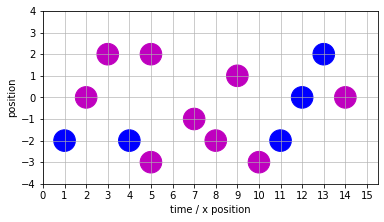

In [16]:
# Plot the planetary locations

def plot_planet_locations(ax) :
    plt.axis([0,15.5,-4,4])
    major_ticks = np.arange(0, 16, 1)
    ax.set_xticks(major_ticks)
    plt.xlabel("time / x position")
    plt.ylabel("position")
    ax.set_aspect('equal')
    ax.grid(which='major', alpha=0.8)

    # Mark the planet positions onto the plot - read in the data from data/planet_locations.dat
    # HINT: the function you need is called loadtxt
    planet_locations= np.loadtxt("data/planet_locations.dat")

    for index, location in enumerate(planet_locations) :
        is_minshara_class =  (location[2] == 1)
        coordinates = (location[0], location[1])
        if(is_minshara_class) :
            circle=plt.Circle(coordinates, 0.5, color='b')
            plt.gcf().gca().add_artist(circle)
        else : # other planets are dangerous D class planets
            assert location[2] == 0 # Check it is not another planet type
            circle=plt.Circle(coordinates, 0.5, color='m')
            plt.gcf().gca().add_artist(circle)  

# Test the plot
fig = plt.figure()
ax = plt.gcf().gca()
plot_planet_locations(ax)
plt.show()

### ACTIVITY 4:

Update the code below to make sure you visit all the M class planets as your Captain has asked (same rules of motion as above). What is the shortest distance in which you can do this? Update the code to calculate your value.

Again, you should _first write code that checks that the code does what it should_, and then implement the actual actions.

In [17]:
# Rule 4: Check we visited all the M class planets
def test_visited_planets(a_list_of_times, a_list_of_y_positions) :
    planet_data = np.loadtxt("data/planet_locations.dat")
    for idat, planet_datum in enumerate(planet_data) :
        is_m_class_planet = (planet_datum[2] == 1)
        if is_m_class_planet :
            location = (planet_datum[0], planet_datum[1])
            have_visited_planet = False
            for ix, x_position in enumerate(a_list_of_times) :
                locations_match = (a_list_of_times[ix] == location[0] and a_list_of_y_positions[ix] == location[1])
                if (locations_match) :
                    have_visited_planet = True
                                   
            message = 'You have missed the planet at ' + str(location)
            assert have_visited_planet, message
            
# Test for the test
# list_of_times = np.arange(16)
# broken_list_of_y_positions = np.array([ 0, -2, -2, -2, -2, -2, -2, -2, -3, -2, -2, -2,  0,  2,  1,  0])
# test_visited_planets(list_of_times, broken_list_of_y_positions)

In [10]:
# Plot again the asteroid field, so that we can plot the path on top of it
#plt.ion() # Make the plotting interactive so we can update the path as we fly
fig = plt.figure()
ax = plt.gcf().gca()
plot_planet_locations(ax)   

# set up a list to store the times and positions
final_time = 15
list_of_times = np.arange(final_time+1)
list_of_y_positions = np.zeros_like(list_of_times)

# print off the initial values of the times and positions
print("The list of times at the start is ", list_of_times)
print("The list of positions at the start is ", list_of_y_positions)
print("The time taken to plot the course was ", end_time - start_time, " seconds")

start_time = time.time()

# go through the list of times, where index is the index within the 
# list, and time_now is the entry at that index
for index, time_now in enumerate(list_of_times) :
    
    if (time_now == 9) :
        step_size = 1
        
        
    elif (time_now > 11 and time_now == 14) :
        step_size = 2
    
    elif (time_now > 0 and time_now < 2) :
        step_size = -2

    # if the time is equal to to the last element
    elif (time_now == np.size(list_of_y_positions) - 1) :
        # move back to the start in one timestep
        step_size = - list_of_y_positions[index - 1]

    # finally, give the default option for all other cases using 'else'
    else :
        # nothing happens at other times
        step_size = 0
    
    if(index > 0) :
        list_of_y_positions[index] = list_of_y_positions[index - 1] + step_size
    
    else :
        list_of_y_positions[index] = 0

    position_now = list_of_y_positions[index]
    plt.plot(time_now, position_now, 'o')
    #plt.pause(0.2)
    
end_time = time.time()

print("The list of times at the end is ", list_of_times)
print("The list of positions at the end is ", list_of_y_positions)

plt.plot(list_of_times, list_of_y_positions, 'g-')
plt.show()
test_visited_planets(list_of_times, list_of_y_positions)
test_final_position(list_of_y_positions)

# Uncomment to save the figure
# plt.savefig("PlanetPath.png")

# Calculate and print out some information
total_distance_moved = calculate_distance_travelled(list_of_times, list_of_y_positions)
print("I moved a total of ", total_distance_moved, " units")

NameError: name 'plt' is not defined

### ACTIVITY 5:

Which software carpentry features are already implemented?

1. There are comments to help the reader know what is happening, but not too many
2. The names respect the rules about functions being verbs, variables being nouns and bools being questions.
3. The names of the functions / variables make it readable even without comments, they are not abbreviated
4. It is saved in GitHub
5. It has tests implemented before the code was implemented
6. The tests use assertions to check validity of data
7. Where there are similar operations on e.g. x and y coordinates, I try to align the code blocks so that the y are directly under the x (see for example distance_to_asteroid) - this aids visual debugging by checking the indices match

### ACTIVITY 6:

*Timing*: the code is very short but it is still useful to time the `for` loop to see how long it is taking and understand how it could be optimised. Add something that returns the time taken for it to run. Change the pause time for the plotting and check that the time to run changes appropriately. (I would just google "how to time function in python").

### ACTIVITY 7:

Suggest other ways to improve the code. Free to use your imagination and suggest major changes (you don't need to implement them unless you want to).

1. The use of elements of list_of_times as interchangeable with x coordinates is a bit poor - one should really define a speed and use that to calculate a list_of_x_positions from the times. 

2. Better still, since the rules require one step forward at every times step, we could probably do away with the list_of_times altogether and create the x coordinates in the loop - then we wouldn't need an assert to check the list hasn't been modified. 

3. It would be better to save and access the x and y coordinates as a list of tuples (x,y) rather than having them in separate vectors.

4. Maybe we could figure out the step_size needed dynamically by checking the next x-coordinate locations ahead for asteroids or planets, and minimising the distance moved. Disadvantage : this will find a local minimum distance at each step but not the global one, but is more liked to be how an AI system would navigate in time.

5. We could write a path finder algorithm like those used by google maps to find the minimum path avoiding or visiting certain points.

Please let me know any other ideas you had and I would be happy to add them here!